# Анализ гипотез для увеличения выручки

В нашем распоряжении данные о гипотезах для увеличения выручки. 
Задачи - приоритизирывать гипотезы и запустить A/B-тест. Цель - принятие решения по результатам теста. 

**Описание данных:**

**Данные для первой части**

Файл /datasets/hypothesis.csv

- Hypothesis — краткое описание гипотезы;

- Reach — охват пользователей по 10-балльной шкале;

- Impact — влияние на пользователей по 10-балльной шкале;

- Confidence — уверенность в гипотезе по 10-балльной шкале;

- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv

- transactionId — идентификатор заказа;

- visitorId — идентификатор пользователя, совершившего заказ;

- date — дата, когда был совершён заказ;

- revenue — выручка заказа;

- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv

- date — дата;

- group — группа A/B-теста;

- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
pd.options.display.max_colwidth = 150
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [6]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
orders.duplicated().sum()

0

In [11]:
orders['transactionId'].value_counts()

1658608862    1
2211880073    1
3913205113    1
437656952     1
3592105335    1
             ..
2872509092    1
2013919907    1
3154167297    1
2960804513    1
4281129020    1
Name: transactionId, Length: 1197, dtype: int64

In [12]:
orders['visitorId'].value_counts()

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2406916810     1
1255412427     1
3866069709     1
54447517       1
3013339133     1
Name: visitorId, Length: 1031, dtype: int64

In [13]:
orders['date'].value_counts()

2019-08-05    48
2019-08-12    47
2019-08-14    47
2019-08-15    46
2019-08-06    46
2019-08-01    45
2019-08-28    45
2019-08-02    44
2019-08-27    44
2019-08-08    43
2019-08-19    43
2019-08-29    42
2019-08-07    42
2019-08-26    41
2019-08-22    41
2019-08-09    41
2019-08-03    40
2019-08-23    40
2019-08-10    39
2019-08-16    38
2019-08-21    37
2019-08-30    35
2019-08-13    35
2019-08-04    33
2019-08-20    32
2019-08-31    32
2019-08-24    31
2019-08-18    26
2019-08-11    26
2019-08-17    24
2019-08-25    24
Name: date, dtype: int64

In [14]:
print(orders['date'].min())

2019-08-01 00:00:00


In [15]:
print(orders['date'].max())

2019-08-31 00:00:00


In [16]:
orders['revenue'].value_counts()

990       17
890       13
390       13
1190      10
400       10
          ..
6440       1
45780      1
725        1
9800       1
202740     1
Name: revenue, Length: 713, dtype: int64

In [17]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [18]:
orders['visitorId'].nunique()

1031

In [19]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [20]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [21]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [22]:
visitors['date'].value_counts()

2019-08-11    2
2019-08-12    2
2019-08-05    2
2019-08-22    2
2019-08-27    2
2019-08-18    2
2019-08-16    2
2019-08-29    2
2019-08-01    2
2019-08-24    2
2019-08-09    2
2019-08-30    2
2019-08-25    2
2019-08-20    2
2019-08-08    2
2019-08-06    2
2019-08-17    2
2019-08-31    2
2019-08-13    2
2019-08-23    2
2019-08-21    2
2019-08-03    2
2019-08-02    2
2019-08-07    2
2019-08-15    2
2019-08-28    2
2019-08-26    2
2019-08-10    2
2019-08-14    2
2019-08-04    2
2019-08-19    2
Name: date, dtype: int64

In [23]:
print(visitors['date'].min())

2019-08-01


In [24]:
print(visitors['date'].max())

2019-08-31


In [25]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [26]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

In [27]:
visitors['visitors'].value_counts()

610    2
718    2
654    2
490    2
609    1
717    1
719    1
720    1
721    1
594    1
722    1
468    1
595    1
756    1
735    1
769    1
711    1
668    1
487    1
361    1
746    1
619    1
748    1
621    1
369    1
628    1
709    1
378    1
507    1
713    1
581    1
770    1
413    1
644    1
646    1
650    1
395    1
655    1
737    1
531    1
502    1
406    1
667    1
412    1
543    1
707    1
544    1
546    1
676    1
421    1
617    1
679    1
560    1
656    1
699    1
575    1
577    1
509    1
Name: visitors, dtype: int64

Проведена проверка данных в 3 таблицах, были изменены типы данных в некоторых столбцах, дубликатов в значениях не обнаружено.

In [28]:
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

In [29]:
orders['visitorId'].nunique()

1031

В таблице orders 58 пользователей попавших в обе группы, то есть 5,6% от общего числа пользователей. Стоило бы исключить этих пользователей из анализа, но в таблице visitors данные обезличины, поэтому исключить данные не получится.

### Часть 1. Приоритизация гипотез

In [30]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [31]:
hypothesis['ICE']= round(hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts'], 2)

In [32]:
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [33]:
hypothesis['RICE']= round(hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts'], 2)

In [34]:
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Лидеры таблицы ICE 8, 0, 7,
а таблицы RICE 7, 2, 0.
Изменение произошло потому что в таблице RICE мы учитывали то, насколько изменение затронет текущих пользователей, а в 7 гипотезе Reach максимальный.

### Часть 2. Анализ A/B-теста

#### Построим график кумулятивной выручки по группам

In [35]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [36]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


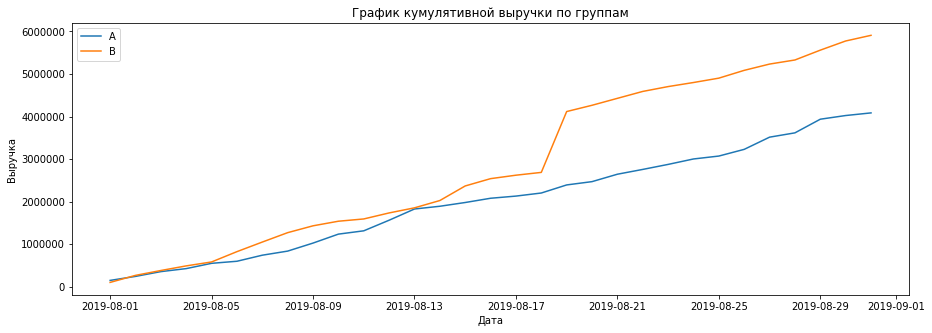

In [37]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(style='plain')

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста, однако видно, что в группе В она значительно выше.

#### Построим график кумулятивного среднего чека по группам

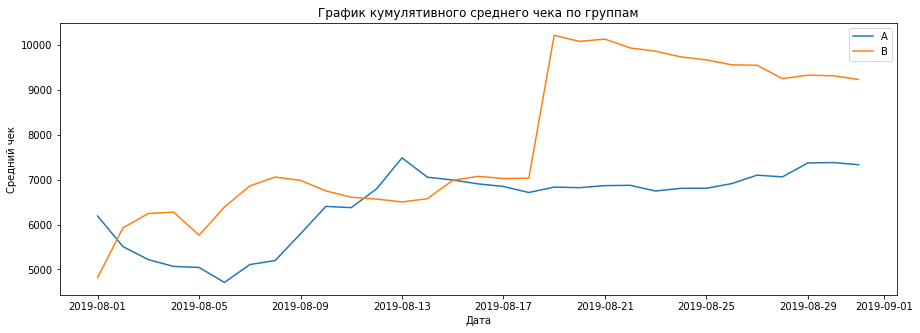

In [38]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(style='plain')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')

plt.show()

Заметно, что с самого начала средний чек в группе В растет быстрее чем в группе А, также заметен резкий всплеск на графике значения группы В 19 числа, что может быть вызвано аномально крупными заказами.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

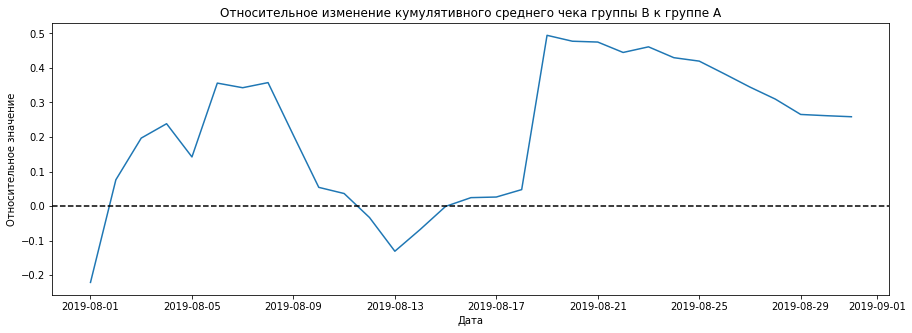

In [39]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(style='plain')

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное значение')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Это означает что в группы попали крупные заказы и выбросы.

#### Построим график кумулятивного среднего количества заказов на посетителя по группам

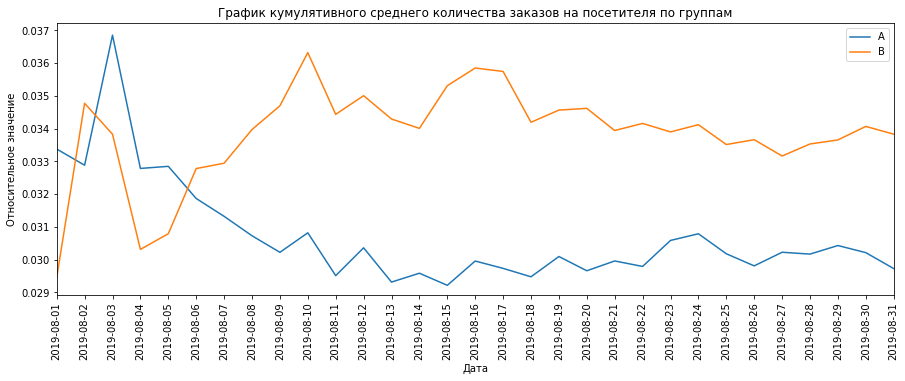

In [40]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

min_value = pd.concat([cumulativeDataA['conversion'], cumulativeDataB['conversion']]).min() * 0.99
max_value = pd.concat([cumulativeDataA['conversion'], cumulativeDataB['conversion']]).max() * 1.01

plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.xticks(cumulativeRevenueA['date'], rotation=90)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Относительное значение')
plt.ylim(min_value, max_value)
plt.show()

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

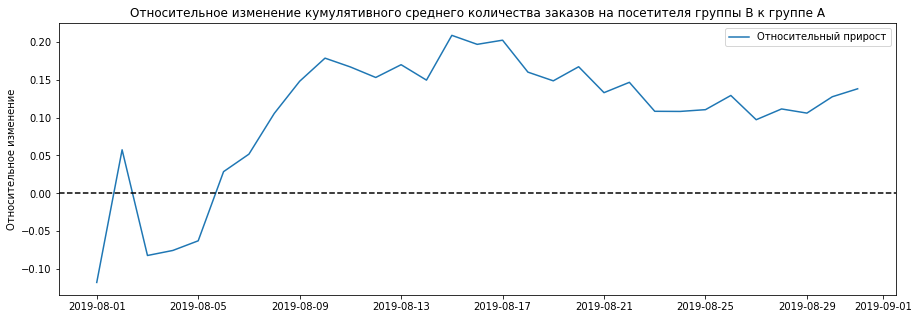

In [41]:
plt.figure(figsize=(15,5))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],\
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост")
plt.legend()
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

#### Построим точечный график количества заказов по пользователям. Сделайте выводы и предположения

In [42]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

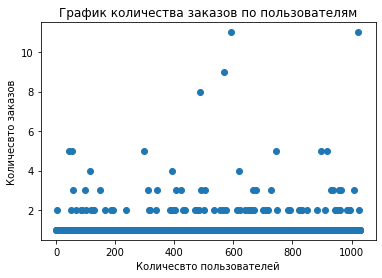

In [43]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.xlabel('Количесвто пользователей')
plt.ylabel('Количесвто заказов')
plt.show()

Больше всего пользователей совершивших 1 заказ, далее этот показатель идет по нисходящей, для определения вбросов расчитаем процентили.

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей

In [44]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


95% пользователей совершают до 2 заказов, а 99% пользователей совершают до 4 заказов.

#### Построим точечный график стоимостей заказов

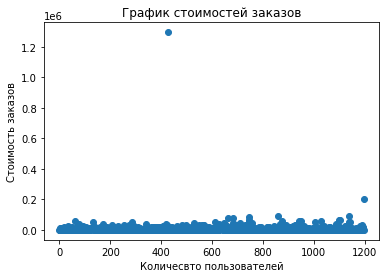

In [45]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('График стоимостей заказов')
plt.xlabel('Количесвто пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Из-за вброса в цене заказа плохо видно основную группу, поэтому построим более наглядный график.

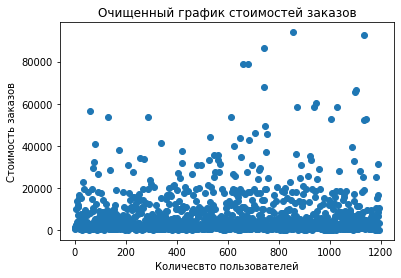

In [46]:
orders_clear = orders[orders['revenue']<=195000]['revenue']
xy_values = pd.Series(range(0,len(orders_clear)))
plt.scatter(xy_values, orders_clear) 
plt.title('Очищенный график стоимостей заказов')
plt.xlabel('Количесвто пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

На первый взгляд большинство заказов не превышает 20000, но для более точных расчетов рассчитаем процентили.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов.

In [47]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Лишь 5% покупателей платили больше 28000, и лишь 1% больше 58223

Таким образом, определим следующие границы для дальнейшего анализа исключив аномальные данные:
    
- верхняя граница количества заказов на одного пользователя - до 2-х заказов включительно;
    
- верхняя граница стоимости одного заказа - до 28000.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулируем гипотезы. 
- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем количестве заказов между группами есть.

In [48]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [49]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [50]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value ' "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный выигрыш группы B по отношению к группе A '"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value 0.017
Относительный выигрыш группы B по отношению к группе A 0.138


P-value меньше 0.05. Значит, нулевую гипотезу, о том, что статистически значимых различий в среднем количестве заказов между группами нет, отвергаем. То есть различия в среднем количестве заказов между группами есть, а относительный выигрыш группы В над группой А составляет 13,8%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Далее проверим статистическую значимость различий в среднем чеке между группами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [51]:
print('P-value ''{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница в среднем чеке ''{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value 0.729
Относительная разница в среднем чеке 0.259


P-value больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке двух групп нет отвергать нет оснований. Но при этом разница в среднем чеке  группы В над группой А составляет 25,9%.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Очистим данные от выбросов, и будем придерживаться большинства в 95% пользователей, где количество заказов будет не больше 2, а сумма заказов не больше 28000.

In [52]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
74


Всего 74 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.

In [53]:
#посчитаем относительные потери пользователей
x =  ((abnormalUsers.count() / orders['visitorId'].nunique()) * 100).round(2)
x

7.18

Относительные потери пользователей составиляют 7.18%.

In [54]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [55]:
print('P-value ' '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница в среднем чеке ''{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value 0.013
Относительная разница в среднем чеке 0.173


После того как были исключены аномальные значения получили следующие результаты:

- отвергаем нулевую гипотезу, различий в среднем чеке между группами нет;

- относительный выигрыш группы В над группой А вырос с 13,8% до 17,3%.

Далее проверим изменилось ли что-нибудь с результатами по среднему чеку.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [56]:
print('P-value '
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Разница между сегментами '
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value 0.738
Разница между сегментами -0.020


После того как были исключены аномальные значения получили следующие результаты:

- гипотеза о том, что различий в среднем чеке между группами нет подтвердилась;

- в очищенных данных средний чек группы В оказался на 2% ниже группы А (ранее средний чек группы В был выше группы А на 26%).


#### Решение по результатам теста
В результате эксперимента было выявленно, что существует значительная разница в среднем количестве заказов между группами, в группе В она выше на 17,3%. Также было выявленно что по очищенным данным средний чек группы В ниже на 2%. 
Таким образом, мы делаем вывод, что тест необходимо остановить и зафиксировать победу группы В из-за значительной разницы в среднем количестве заказов В.


### Вывод

 В результате выполненного анализа данных мы приходим к следующим выводам:
 
 - Данные были собраны корректно, дубликатов и пропусков не было обнаружено;
 
 - Анализ гипотез показал, что лидеры таблицы ICE 8, 0, 7 а таблицы RICE 7, 2, 0. Изменение мест гипотез произошел потому, что в таблице RICE мы учитывали то, насколько изменение затронет текущих пользователей, а в 7 гипотезе Reach максимальный, поэтому она и является самой приоритетной.
 
 - Были проанализированны результаты А/В теста, и обнаруженно следующее:
 Выручка почти равномерно увеличивается в течение всего теста, однако видно, что в группе В она значительно выше;
 С самого начала средний чек в группе В растет быстрее чем в группе А, также есть резкий всплеск на графике значения группы В 19 числа, что может быть связано с аномально крупными заказами;
 В начале периода среднее количество заказов на посетителя в группе А было выше, однако после 6 числа среднее количество заказов на посетителя группы В вырвалось вперед и зафиксировалось;
 95% пользователей совершают до 2 заказов, а 99% пользователей совершают до 4 заказов;
 Лишь 5% покупателей платили больше 28000, и лишь 1% больше 58223;
 И в результате эксперимента было выявленно, что существует значительная разница в среднем количестве заказов между группами, в группе В она выше на 17,3%. Также было выявленно что по очищенным данным средний чек группы В ниже на 2%. 
Таким образом, мы делаем вывод, что тест необходимо остановить и зафиксировать победу группы В из-за значительной разницы в среднем количестве заказов В.